In [60]:
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import pandas as pd
import os
from datetime import datetime

auth = earthaccess.login(persist=True)

In [75]:
baseline_results = []
for year in range(2003, 2014):  # 2003 through 2015
    baseline_data = earthaccess.search_data(
        short_name="MODISA_L3m_CHL",
        temporal=(f"{year}-05-01", f"{year}-05-31"),
        granule_name="*.MO.*.4km.*",
    )
    baseline_results.extend(baseline_data)
    print(f"Found {len(baseline_data)} datasets for January {year}")

baseline_paths = earthaccess.open(baseline_results)

Found 1 datasets for January 2003
Found 1 datasets for January 2004
Found 1 datasets for January 2005
Found 1 datasets for January 2006
Found 1 datasets for January 2007
Found 1 datasets for January 2008
Found 1 datasets for January 2009
Found 1 datasets for January 2010
Found 1 datasets for January 2011
Found 1 datasets for January 2012
Found 1 datasets for January 2013


QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

In [76]:
baseline_sum = None
baseline_count = None

In [77]:
for i, path in enumerate(baseline_paths):
    print(f"Processing baseline dataset {i+1}/{len(baseline_paths)}")
    
    try:
        dataset = xr.open_dataset(path)
        
        chl_var = "chlor_a"
        if chl_var not in dataset.data_vars:
            possible_vars = [var for var in dataset.data_vars if 'chl' in var.lower()]
            if possible_vars:
                chl_var = possible_vars[0]
        
        data = dataset[chl_var].values
        
        if baseline_sum is None:
            baseline_sum = np.zeros_like(data)
            baseline_count = np.zeros_like(data)
            lat = dataset['lat'].values if 'lat' in dataset.coords else dataset['Latitude'].values
            lon = dataset['lon'].values if 'lon' in dataset.coords else dataset['Longitude'].values
        
        valid_mask = ~np.isnan(data)
        baseline_sum[valid_mask] += data[valid_mask]
        baseline_count[valid_mask] += 1
        
        dataset.close()
        
    except Exception as e:
        print(f"Error processing baseline dataset {i+1}: {e}")
        continue

baseline_mean = np.where(baseline_count > 0, 
                        baseline_sum / baseline_count, 
                        np.nan)

print(f"Baseline calculated from {len(baseline_paths)} datasets")

Processing baseline dataset 1/11
Processing baseline dataset 2/11
Processing baseline dataset 3/11
Processing baseline dataset 4/11
Processing baseline dataset 5/11
Processing baseline dataset 6/11
Processing baseline dataset 7/11
Processing baseline dataset 8/11
Processing baseline dataset 9/11
Processing baseline dataset 10/11
Processing baseline dataset 11/11
Baseline calculated from 11 datasets


/tmp/ipykernel_101/2026439165.py:32: RuntimeWarning: invalid value encountered in divide
  baseline_sum / baseline_count,


In [78]:
baseline_mean = np.where(baseline_count > 0, baseline_sum / baseline_count, np.nan)
baseline_log = np.where((baseline_mean > 0) & ~np.isnan(baseline_mean), np.log10(baseline_mean), np.nan)

/tmp/ipykernel_101/3983323977.py:1: RuntimeWarning: invalid value encountered in divide
  baseline_mean = np.where(baseline_count > 0, baseline_sum / baseline_count, np.nan)


In [80]:
target_results = earthaccess.search_data(
    short_name="MODISA_L3m_CHL",
    temporal=(f"{2015}-05-01", f"{2015}-05-31"),
    granule_name="*.MO.*.4km.*",
)

print(f"Found {len(target_results)} datasets for January {2015}")
target_paths = earthaccess.open(target_results)

Found 1 datasets for January 2015


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [81]:
target_sum = None
target_count = None

In [82]:
for i, path in enumerate(target_paths):
    print(f"Processing 2015 dataset {i+1}/{len(target_paths)}")
    
    try:
        dataset = xr.open_dataset(path)
        
        chl_var = "chlor_a"
        if chl_var not in dataset.data_vars:
            possible_vars = [var for var in dataset.data_vars if 'chl' in var.lower()]
            if possible_vars:
                chl_var = possible_vars[0]
        
        data = dataset[chl_var].values
        
        if target_sum is None:
            target_sum = np.zeros_like(data)
            target_count = np.zeros_like(data)
        
        valid_mask = ~np.isnan(data)
        target_sum[valid_mask] += data[valid_mask]
        target_count[valid_mask] += 1
        
        dataset.close()
        
    except Exception as e:
        print(f"Error processing 2015 dataset {i+1}: {e}")
        continue

Processing 2015 dataset 1/1


In [83]:
target_mean = np.where(target_count > 0, target_sum / target_count, np.nan)
target_log = np.where((target_mean > 0) & ~np.isnan(target_mean), np.log10(target_mean), np.nan)

/tmp/ipykernel_101/1933369694.py:1: RuntimeWarning: invalid value encountered in divide
  target_mean = np.where(target_count > 0, target_sum / target_count, np.nan)


In [84]:
log_anomaly = target_log - baseline_log

valid_log_anomaly_mask = ~(np.isnan(baseline_log) | np.isnan(target_log))
log_anomaly[~valid_log_anomaly_mask] = np.nan

In [85]:
log_vmin, log_vmax = -2, 1
log_anomaly_vmax = np.nanpercentile(np.abs(log_anomaly), 95)

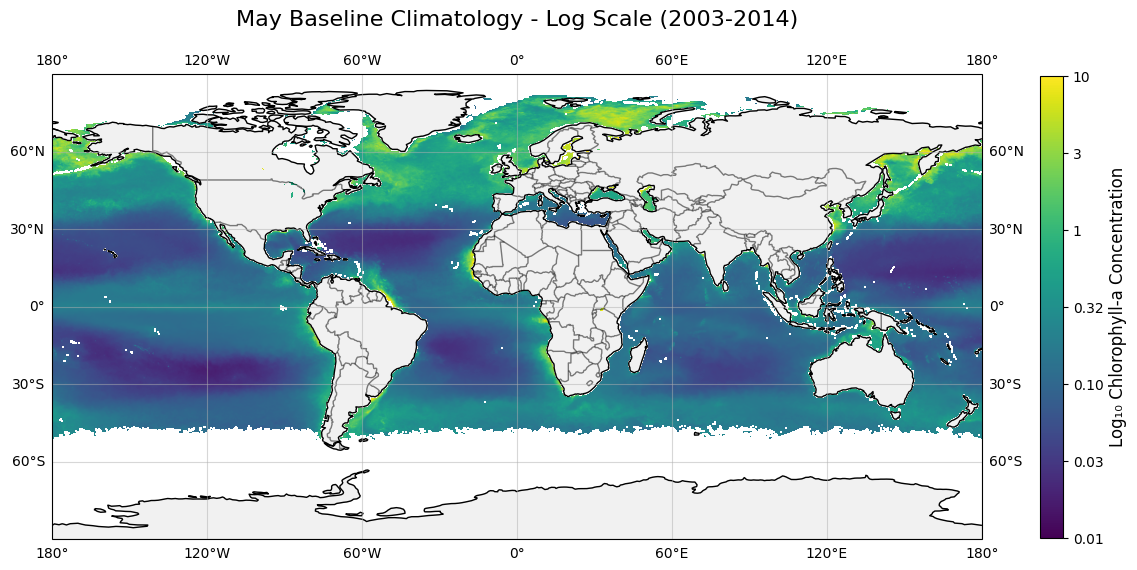

In [86]:
fig1, ax1 = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

im1 = ax1.imshow(baseline_log, 
                 extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                 transform=ccrs.PlateCarree(),
                 cmap='viridis',
                 vmin=log_vmin, vmax=log_vmax)

ax1.coastlines(resolution='110m')
ax1.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
ax1.add_feature(cfeature.BORDERS, alpha=0.5)
ax1.gridlines(draw_labels=True, alpha=0.5)
ax1.set_global()

cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.6, pad=0.05)
cbar1.set_label('Log₁₀ Chlorophyll-a Concentration', fontsize=12)

log_ticks = np.arange(-2, 1.5, 0.5)
actual_values = 10**log_ticks
cbar1.set_ticks(log_ticks)
cbar1.set_ticklabels([f'{val:.2f}' if val < 1 else f'{val:.0f}' for val in actual_values])

plt.title(f'May Baseline Climatology - Log Scale ({2003}-{2014})', fontsize=16, pad=20)

#save_path1 = f'01_January_Baseline_Log_Climatology_{2003}_{2014}.png'
#plt.savefig(save_path1, dpi=300, bbox_inches='tight')
plt.show()

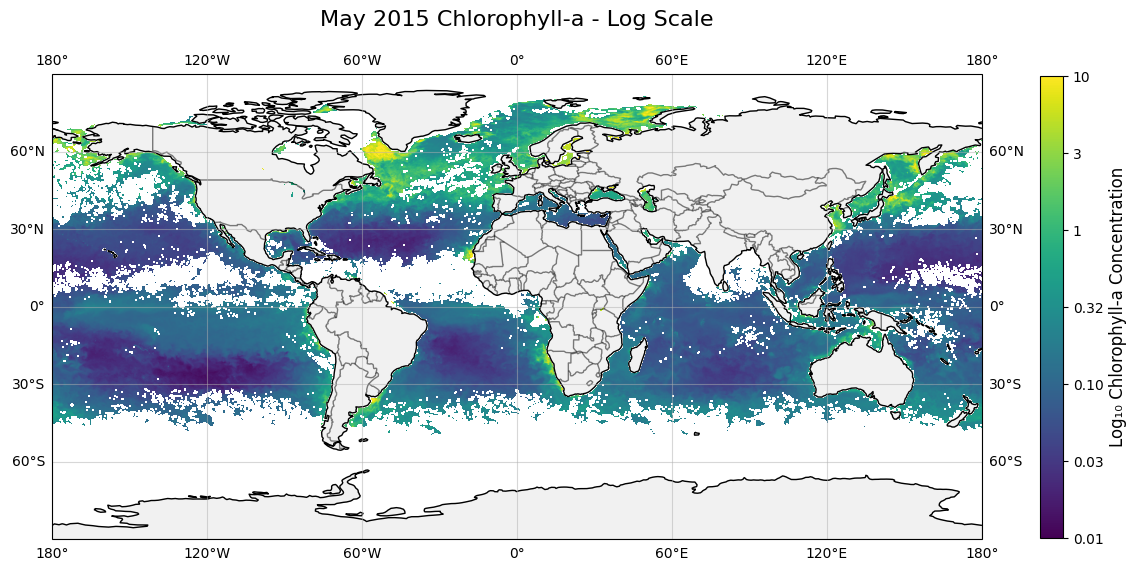

In [87]:
fig2, ax2 = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

im2 = ax2.imshow(target_log, 
                 extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                 transform=ccrs.PlateCarree(),
                 cmap='viridis',
                 vmin=log_vmin, vmax=log_vmax)

ax2.coastlines(resolution='110m')
ax2.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
ax2.add_feature(cfeature.BORDERS, alpha=0.5)
ax2.gridlines(draw_labels=True, alpha=0.5)
ax2.set_global()

cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.6, pad=0.05)
cbar2.set_label('Log₁₀ Chlorophyll-a Concentration', fontsize=12)

cbar2.set_ticks(log_ticks)
cbar2.set_ticklabels([f'{val:.2f}' if val < 1 else f'{val:.0f}' for val in actual_values])

plt.title(f'May {2015} Chlorophyll-a - Log Scale', fontsize=16, pad=20)

#save_path2 = f'02_January_{2015}_Log_Chlorophyll.png'
#plt.savefig(save_path2, dpi=300, bbox_inches='tight')
plt.show()

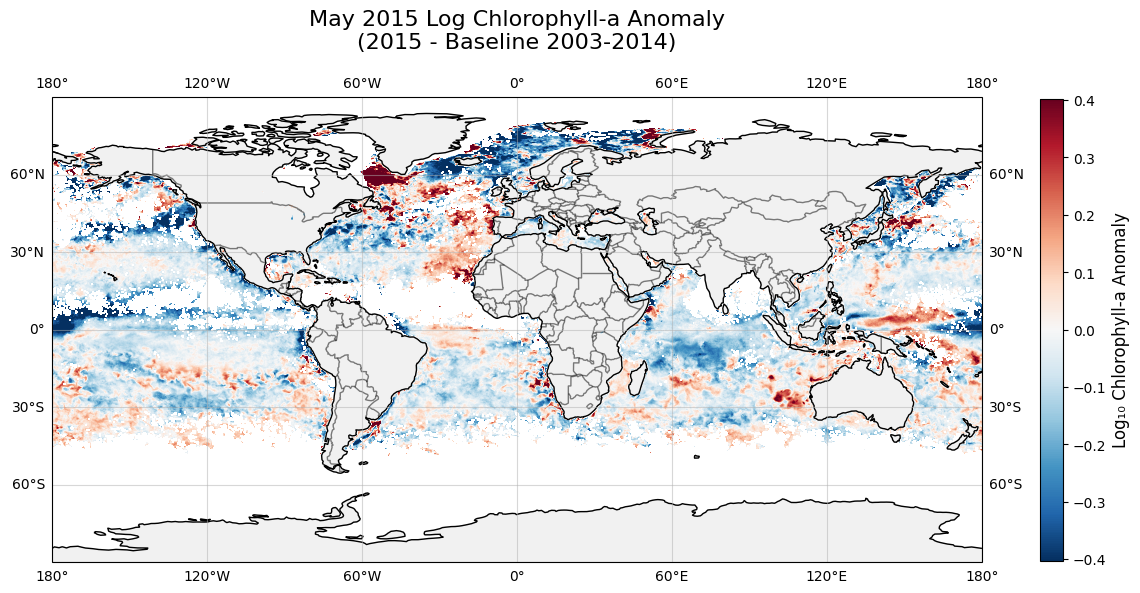

In [88]:
fig3, ax3 = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

im3 = ax3.imshow(log_anomaly, 
                 extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                 transform=ccrs.PlateCarree(),
                 cmap='RdBu_r',
                 vmin=-log_anomaly_vmax, vmax=log_anomaly_vmax)

ax3.coastlines(resolution='110m')
ax3.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
ax3.add_feature(cfeature.BORDERS, alpha=0.5)
ax3.gridlines(draw_labels=True, alpha=0.5)
ax3.set_global()

cbar3 = plt.colorbar(im3, ax=ax3, shrink=0.6, pad=0.05)
cbar3.set_label('Log₁₀ Chlorophyll-a Anomaly', fontsize=12)

plt.title(f'May {2015} Log Chlorophyll-a Anomaly\n({2015} - Baseline {2003}-{2014})', fontsize=16, pad=20)

#save_path3 = f'03_January_{2015}_Log_Anomaly.png'
#plt.savefig(save_path3, dpi=300, bbox_inches='tight')
plt.show()